# Network Linear Programs
[![network.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/network.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/network.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/network.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/network.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/network.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/network.ipynb)](https://colab.ampl.com)

Description: Basic introduction to network linear programms and AMPL via max flow and shortest path problems

Tags: ampl-lecture, amplpy, ampl, introduction, linear programming, max flow, shortest path

Notebook author: Gyorgy Matyasfalvi <<gyorgy@ampl.com>>

References: 

* AMPL a Modeling Language for Mathematical Programming -- Robert Fourer et al.
* Linear Programming (Foundations and Extensions) -- Robert J. Vanderbei
* Network Flows -- Ravindra K. Ahuja et al.

In [1]:
# Install dependencies
%pip install -q amplpy pandas numpy matplotlib networkx

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [3]:
# Import all necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
from math import log, cos, sin, pi, sqrt

Network problems lend themselves to graphical visualization. In these visual representations, nodes of the network are depicted as circles, while arrows represent the edges connecting one node to another. Flow, which can take various forms, traverses the network from node to node following the direction indicated by the arrows.

The realm of network optimization models is vast and varied. Many models cannot be easily encapsulated by straightforward algebraic formulations or pose significant challenges in their resolution. Our focus will be on a subset of network optimization models where the decision variables correspond to the flow volumes on the edges. The constraints we consider are twofold: we have simple bounds governing the flow volumes and we enforce the principle of flow conservation at the nodes. Such restrictions define the scope of network linear programming problems. These problems are not only straightforward to articulate and resolve but also boast broad applicability.

In our concluding discussion, we will explore some unexpected characteristics of network linear models and discuss why framing your optimization challenges within this context is highly advantageous when feasible.

## Define a function for plotting networks

In [4]:
# Function to plot the graph
def plot_graph(Graph, plot_pos, node_colors=None, edge_colors=None, edge_labels=None):
    """
    Plots a graph with the given positions, colors, and labels
    """
    # Default color for all nodes and edges
    default_node_color = "lightblue"
    default_edge_color = "black"

    # Create color lists
    node_color_list = [
        (
            default_node_color
            if node_colors is None
            else node_colors.get(node, default_node_color)
        )
        for node in Graph.nodes()
    ]
    edge_color_list = [
        (
            default_edge_color
            if edge_colors is None
            else edge_colors.get(edge, default_edge_color)
        )
        for edge in Graph.edges()
    ]

    # Plot the graph
    nx.draw_networkx_nodes(Graph, plot_pos, node_size=500, node_color=node_color_list)
    nx.draw_networkx_edges(
        Graph, plot_pos, width=2, arrowsize=10, edge_color=edge_color_list
    )
    nx.draw_networkx_labels(Graph, plot_pos, font_size=10, font_family="sans-serif")
    if edge_labels is not None:
        nx.draw_networkx_edge_labels(
            Graph, plot_pos, edge_labels=edge_labels, label_pos=0.5, font_size=15
        )
    plt.axis("off")  # Turn off axis
    plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
    plt.show()

## Introduce our problem data and plot the network

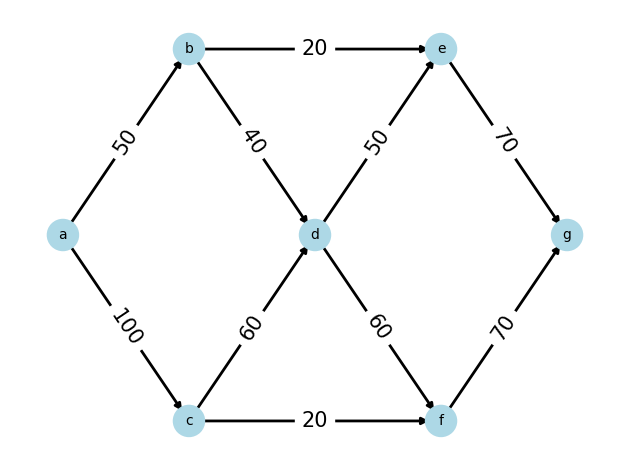

In [5]:
# Data for the problem
NODES = ["a", "b", "c", "d", "e", "f", "g"]
EDGES = [
    ("a", "b"),
    ("a", "c"),
    ("b", "d"),
    ("b", "e"),
    ("c", "d"),
    ("c", "f"),
    ("d", "e"),
    ("d", "f"),
    ("e", "g"),
    ("f", "g"),
]
weights = [50, 100, 40, 20, 60, 20, 50, 60, 70, 70]
weights_df = pd.DataFrame(
    {"weights": weights}, index=pd.MultiIndex.from_tuples(EDGES, names=["from", "to"])
).reset_index()
ppos = {
    "a": (0, 1),
    "b": (1, 2),
    "c": (1, 0),
    "d": (2, 1),
    "e": (3, 2),
    "f": (3, 0),
    "g": (4, 1),
}
G = nx.from_pandas_edgelist(
    weights_df, "from", "to", edge_attr="weights", create_using=nx.DiGraph()
)
elabels = nx.get_edge_attributes(G, "weights")

# Plot the graph
plot_graph(Graph=G, plot_pos=ppos, edge_labels=elabels)

## Maximum Flow Models

In certain network design applications, the primary goal is to maximize the throughput, routing as much flow as possible through the network. We will later address the objective of minimizing the cost of flow. In maximum flow models, our variables represent the flow through the network's edges, and the objective function aims to maximize the flow entering the network.

Above is a depiction of a straightforward traffic network.

We must implement balance constraints at every node, except for the start and finish nodes, to ensure that the flow into a node is equal to the flow out. The edges' weights serve as capacity limits, indicating the maximum flow they can handle, measured in units such as cars per hour. Additionally, we stipulate that the flow must be nonnegative.

Here, the nodes symbolize intersections, and the edges symbolize roads. The weights, indicated by numbers on the edges, represent capacity in cars per hour. Our objective is to determine the maximal flow of traffic that can enter the network at node 'a' and exit at node 'g'.

In [6]:
%%writefile maxflow.mod
set NODES;                                  # Set of nodes     
param start symbolic in NODES;              # Starting point of our network network
param finish symbolic in NODES, != start;   # Finishing point of our network
set EDGES within (NODES diff {finish}) cross (NODES diff {start}); # Set of edges

param weights {EDGES} >= 0;                       # Weight of each edge
var Flow {(i,j) in EDGES} >= 0, <= weights[i,j];  # Network flow

maximize Entering_Flow: sum {(start,j) in EDGES} Flow[start,j]; # Maximize the flow entering the network

subject to Balance {k in NODES diff {start,finish}}:
  sum {(i,k) in EDGES} Flow[i,k] = sum {(k,j) in EDGES} Flow[k,j];  # Flow entering a node is equal to the flow leaving a node except for the start and finish nodes.

Writing maxflow.mod


### Solving the problem
Upon inputting the aforementioned network into our model and solving the problem, we ascertain that the maximum flow achievable is 130 cars per hour.

In [7]:
# Create an AMPL instance
ampl = AMPL()
# Load the model file
ampl.read("maxflow.mod")

# Load the data
ampl.set["NODES"] = NODES
ampl.set["EDGES"] = EDGES
ampl.param["start"] = "a"
ampl.param["finish"] = "g"
# Make sure we adjust the index to be determined by the 'from' and 'to' columns
ampl.set_data(weights_df.set_index(["from", "to"]))

# Solve the problem
ampl.option["solver"] = "highs"
ampl.solve()

HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 130
4 simplex iterations
0 barrier iterations
 


## Visualizing the solution

1. We will extract the solution from AMPL and compare the flow values against the edges' weights. If the flow value equals the edge's weight, it indicates that the edge is fully saturated; hence, we cannot increase the flow through that edge any further.

2. In the visualization, we will label saturated edges with a '0' and color them red to indicate they are at full capacity. Edges with remaining capacity will be colored green and labeled with the value of the remaining, signifying that additional flow can still be accommodated.

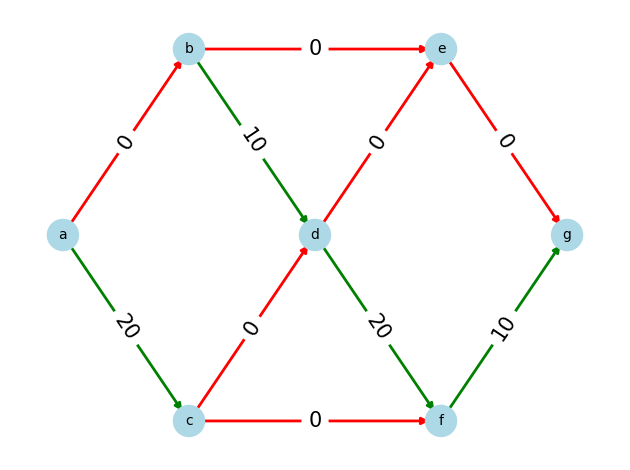

In [8]:
# Retrieve the solution
flows_df = (
    ampl.get_data("Flow")
    .to_pandas()
    .reset_index()
    .rename(columns={"index0": "from", "index1": "to"})
)

# Merge flows_df and weights_df
merged_df = pd.merge(flows_df, weights_df, on=["from", "to"])

# Create a new column 'color'
merged_df["color"] = np.where(merged_df["Flow"] == merged_df["weights"], "red", "green")
# Convert the 'from', 'to', and 'color' columns to a dictionary
ecolors = {(row["from"], row["to"]): row["color"] for _, row in merged_df.iterrows()}

# Create a new column 'difference'
merged_df["difference"] = merged_df["weights"] - merged_df["Flow"]
# Convert the 'from', 'to', and 'difference' columns to a dictionary
elabels = {
    (row["from"], row["to"]): row["difference"] for _, row in merged_df.iterrows()
}

# Call the plot function
plot_graph(Graph=G, plot_pos=ppos, edge_colors=ecolors, edge_labels=elabels)

## NETWORK EXERCISE
1. Alter the `maxflow.mod` model to shift its focus from solving the maximum flow problem from node 'a' to node 'g' to solving the shortest path problem from node 'a' to node 'g'. Start by typing `%%writefile shortestpath.mod` in a code cell below.


2. After deriving a solution, proceed to visualize the shortest path identified by the model.

## SOLUTION
1. Converting the maximum flow model into a shortest path model requires only minor modifications. Specifically, we need to alter the objective function to minimize the sum of the costs incurred by the flow through the network. Additionally, it is essential to introduce a constraint ensuring that precisely one unit of flow is allowed to leave the starting node.

In [9]:
%%writefile shortestpath.mod
set NODES;                                  # Set of nodes 
param start symbolic in NODES;              # Starting point of our network network
param finish symbolic in NODES, != start;   # Finishing point of our network
set EDGES within (NODES diff {finish}) cross (NODES diff {start}); # Set of edges

param weights {EDGES} >= 0;                       # Weight of each edge
var Flow {(i,j) in EDGES} >= 0;                   # Network flow

minimize cost: sum {(i,j) in EDGES} weights[i,j] * Flow[i,j]; # Minimize the cost of flow across the network

subject to Balance {k in NODES diff {start,finish}}:
  sum {(i,k) in EDGES} Flow[i,k] = sum {(k,j) in EDGES} Flow[k,j];  # Flow entering a node is equal to the flow leaving a node except for the start and finish nodes.

subject to Start:
  sum {(start,j) in EDGES} Flow[start,j] = 1; # Flow entering the network is 1

Writing shortestpath.mod


## Load the new model and solve

In [10]:
# Create an AMPL instance
ampl = AMPL()
# Load the model file
ampl.read("shortestpath.mod")

# Load the data
ampl.set["NODES"] = NODES
ampl.set["EDGES"] = EDGES
ampl.param["start"] = "a"
ampl.param["finish"] = "g"
ampl.set_data(weights_df.set_index(["from", "to"]))

# Solve the problem
ampl.option["solver"] = "highs"
ampl.solve()

HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 140
0 simplex iterations
0 barrier iterations
 


## Visualizing the solution
1. We will retrieve the solution from AMPL; edges with a flow value of 1 will delineate the shortest path from node 'a' to node 'g'. The pandas DataFrame `path_df` will hold the records of edges that have a positive flow, and these will be highlighted in red for clear visualization.

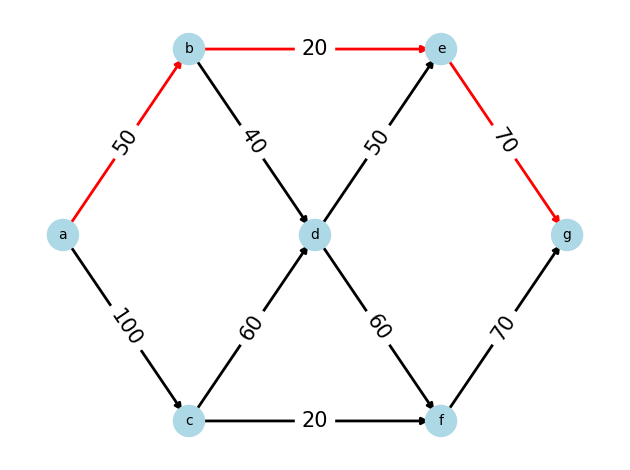

In [11]:
# Retrieve the solution
flows_df = (
    ampl.get_data("Flow")
    .to_pandas()
    .reset_index()
    .rename(columns={"index0": "from", "index1": "to"})
)
# Filter for positive flows, which will indicate the shortest path
path_df = flows_df[flows_df["Flow"] > 0].copy()
path_df["color"] = "red"

# Convert the 'from', 'to', and 'color' columns to a dictionary
ecolors = {(row["from"], row["to"]): row["color"] for _, row in path_df.iterrows()}
# Get the edge weights as lables
elabels = nx.get_edge_attributes(G, "weights")


# Call the plot function
plot_graph(Graph=G, plot_pos=ppos, edge_colors=ecolors, edge_labels=elabels)

In [12]:
# Display the flow variable values
ampl.eval("display Flow;")

Flow :=
a b   1
a c   0
b d   0
b e   1
c d   0
c f   0
d e   0
d f   0
e g   1
f g   0
;



## Concluding Remarks

Upon revisiting the solution and examining the flow values, we observe that they are all integers, despite the absence of any explicit requirement for the flow to be integral. This outcome is not coincidental; it is a highly advantageous characteristic of network linear programs. This phenomenon arises due to the [total unimodularity](https://en.wikipedia.org/wiki/Unimodular_matrix) of the constraint matrix in a network program. As a result, formulating network problems as network linear programs is always beneficial. Doing so ensures that, while solving linear programming problems, we can consistently obtain integer results.